# Предобучение навыков (options)

Нашей задачей будет создание набора навыков по достижению определенных состояний в задаче такси. Для обучения навыков и стратегии над ними воспользуемся полученной ранее реализацией алгоритма Q-обучения.

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [2]:
from collections import defaultdict

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

env = environment = gym.make('Taxi-v3', render_mode='ansi')
env.reset()
# розовый текст: пассажир; синий текст: его дом; желтый: агент (такси)
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Для начала добавим стандартную реализацию Q-обучения.

In [3]:
class QLearningAgent:
    def __init__(self, learning_rate, epsilon, gamma, get_legal_actions, seed=1337):
        self.get_legal_actions = get_legal_actions
        # when called, non-existent values appear as zeros
        self.Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)

    def Qs(self, state, actions):
        return np.array([self.Q[state][action] for action in actions])

    def V(self, state):
        """
        Вычислить полезность состояния относительно целевой (жадной)
        стратегии над доступными (legal) действиями.
        """
        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            return 0.

        return np.max(self.Qs(state, possible_actions))


    def act(self, state, greedy=False):
        """Выбрать эпсилон-жадное действие."""
        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            return None

        if not greedy and self.rng.random() < self.epsilon:
            action = self.rng.choice(possible_actions)
        else:
            best_action_ind = np.argmax(self.Qs(state, possible_actions))
            action = possible_actions[best_action_ind]
        return action

    def update(self, state, action, next_state, reward, terminated):
        """Сделать шаг Q-обучения."""
        # переименуем для краткости формул
        lr, gamma = self.learning_rate, self.gamma
        r, s, a, next_s = reward, state, action, next_state
        not_terminated = int(not terminated)
        Q, V = self.Q, self.V

        td_error = r + gamma * not_terminated * V(next_s) - Q[s][a]
        Q[s][a] += lr * td_error

### Подготовка среды

Теперь разберемся как реализована среда Taxi: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/taxi.py

![taxi](https://gymnasium.farama.org/_images/taxi.gif)

В данной клеточной среде агент выступает в качестве таксиста, которому требуется забрать пассажира и довезти его до дома. Каждый эпизод позиции пассажира и дома выбираются случайно из четырех возможных, отмеченных цветом. Начальная позиция агента также выбирается случайно и может быть любой незанятой.

Так как возможные позиции пассажира и дома ограничены четырьмя клетками, агенту достаточно выучить всего четыре соответствующих им навыка, перемещающих его из любой точки в целевую. Тогда решением задачи будет последовательная комбинация двух навыков "добраться до клетки с пассажиром", "подобрать его", "добраться до клетки с домом".

Чтобы обучить такие навыки, создадим 4 модифицированных окружения, аналогичных Taxi, в которых целью агента будет достижение только одной из возможных точек R, G, B, Y.

(1 балл)

In [4]:
class FixedTargetTaxi(gym.Wrapper):
    def __init__(self, env, target_id, target_reward):
        super().__init__(env)
        # locs хранит список кортежей вида (row, col) всех
        # четырех целевых точек
        self._target = self.unwrapped.locs[target_id]
        self._target_reward = target_reward

    def step(self, action):
        # получаем выход метода step среды,
        # игнорируем вознаграждение и флаг terminated от среды,
        # задаем его сами на основе проверки достижения цели,
        # за каждое действие будем давать вознаграждение
        # -1, за достижение цели - self._target_reward
        state, _, _, truncated, obs = super().step(action)

        # получаем координаты такси
        row, col, *_ = self.unwrapped.decode(state)
        taxi_pos = (row, col)

        ####### Здесь ваш код ########
        if taxi_pos == self._target:
            reward = self._target_reward
            terminated = True
        else:
            reward = -1
            terminated = False
        ##############################
        return state, reward, terminated, truncated, obs

Проверим нашу обертку среды (wrapper), используя случайную стратегию. Порядок точек должен быть следующим: R, G, Y, B.

(2 балла)

In [5]:
# для каждой из 4х возможных целей
for target in range(4):
    # создаем окружение с заданной целью
    ####### Здесь ваш код ########
    fixed_env = FixedTargetTaxi(env, target, 20)
    fixed_env.reset()

    done = False
    ret = 0
    ##############################

    # применяем случайную стратегию,
    # пока эпизод не завершится
    ####### Здесь ваш код ########
    while not done:
        action = np.random.randint(env.action_space.n)
        state, reward, terminated, truncated, obs = fixed_env.step(action)
        done = terminated or truncated
        ret += reward
    ##############################

    # на отрисовке нужно смотреть на позицию клетки желтого цвета
    print(env.render())
    print(f"state:{state} reward:{reward} ret:{ret}")

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

state:3 reward:20 ret:-98
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

state:92 reward:20 ret:-60
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

state:108 reward:-1 ret:-200
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

state:473 reward:20 ret:20


Теперь добавим функцию с циклом обучения агента:

In [6]:
def train_episode(env, agent, is_eval=False):
    s, _ = env.reset()
    ret = 0.0

    while True:
        a = agent.act(s, greedy=is_eval)
        next_s, r, terminated, truncated, _ = env.step(a)
        if not is_eval:
            agent.update(s, a, next_s, r, terminated)
        s = next_s
        ret += r
        if terminated or truncated:
            break
    return ret

### Обучение навыков

Теперь для каждой из четырех возможных целей обучим отдельную стратегию, которую в будущем сможем использовать в качестве навыка. Для обучения навыков создадим четыре пары "агент"-"среда с фиксированной целью" и обучим каждого агента на соответствующей среде.

(2 балла)

In [7]:
rng = np.random.default_rng()

# общие параметры инициализации агентов
params = dict(
    learning_rate=0.1,
    epsilon=0.1,
    gamma=0.99,
    get_legal_actions=lambda s: range(4),
)

# создаем агентов
agents_for_options = [
    QLearningAgent(**params, seed=rng.integers(1_000_000)) for _ in range(4)
]

for index in range(4):
    # создаем обертку окружения с фиксированной целью,
    # используя созданных окружения обучаем агентов
    ####### Здесь ваш код ########
    fixed_env = FixedTargetTaxi(env, index, 20)
    agent = agents_for_options[index]

    for episode in range(5000):
        train_episode(fixed_env, agents_for_options[index])
    ##############################

Для того, чтобы превратить каждую из обученных стратегий четырех агентов в навык (option), требуется дополнительно определить область её действия. Область действия задается множеством начальных состояний, из которых навык может быть начат, и терминальными вероятностями, то есть вероятностями завершения навыка в каждом состоянии.

In [8]:
class Option:
    def __init__(self, policy, initial_states, termination_prob, seed=None):
        self.policy = policy
        self.termination_prob = termination_prob
        self.initial_states = initial_states
        self.rng = np.random.default_rng(seed)

    def can_start(self, state):
        return state in self.initial_states

    def is_terminated(self, state):
        """Проверяет необходимость завершения выполнения навыка"""
        return self.rng.random() <= self.termination_prob[state]

    def act(self, state):
        """Выбирает действие в соответствии со стратегией навыка"""
        # обратите внимание, что навык исполняется с жадной стратегией,
        # т.к. нам не нужно исследование для уже обученного навыка
        return self.policy.act(state, greedy=True)

Создадим объекты навыков на базе обученных ранее стратегий

(1 балл)

In [9]:
options = []
for index, agent in enumerate(agents_for_options):
    # словарь вида состояние: вероятность завершения навыка
    # (используйте бинарные вероятности 0.0 и 1.0)
    termination_prob = {}
    # состояния, в которых навык можно вызвать
    # (все кроме целевых)
    initial_states = set()

    # используйте env.decode(state) для определения координат по
    # состоянию и env.locs[index] для определения координат цели.
    for state in range(500):
        ####### Здесь ваш код ########
        row, col, *_ = env.unwrapped.decode(state)
        pos = (row, col)
        if pos == env.unwrapped.locs[index]:
            termination_prob[state] = 1.0
        else:
            termination_prob[state] = 0.0
            initial_states.add(state)
        ##############################

    options.append(
        Option(
            policy=agent,
            termination_prob=termination_prob,
            initial_states=initial_states
        )
    )

Далее напишем функцию, которая исполняет навык в среде и возвращает совокупное вознаграждение, то есть дисконтированную сумму вознаграждений от среды за все время исполнения навыка:

$$R = r_{1} + \gamma r_{2} + \gamma^{2} r_{3} + \dots + \gamma^{t-1}r_{t}$$

(2 балла)

In [10]:
def apply_option(option, gamma, env, debug=False):
    reward = 0
    gamma_t = 1.0

    state = env.unwrapped.s
    if not option.can_start(state):
        raise KeyError

    # Действуем в соответствии со стратегией навыка до тех пор,
    # пока либо навык, либо эпизод не завершится.
    # В процессе копим дисконтированную сумму вознаграждений.
    ####### Здесь ваш код ########
    while True:
        action = option.act(state)
        state, r, terminated, truncated, obs = env.step(action)
        
        reward += r * gamma_t
        gamma_t *= gamma
        
        if option.is_terminated(state) or terminated or truncated:
            break
    ##############################

    # отрисовка для отображения результата выполнения навыка
    if debug:
        print(env.render())

    return state, reward, terminated, truncated, obs

Итак, теперь у нас есть 4 универсальных навыка. Каждый навык позволяет агенту переместиться из любой точки в целевую (R, G, Y или B). Тогда, чтобы решить любую поставленную задачу, алгоритм работы агента мог бы быть таким:
- определить, в какой из целевых точек находится пассажир
- выбрать и применить соответствующий навык, чтобы добраться до него
- подобрать пассажира
- определить, в какой из целевых точек находится его дом
- выбрать и применить соответствующий навык, чтобы добраться до дома

Давайте проверим работу навыков, вручную реализовав алгоритм выше:

In [11]:
checkpoints = ['R', 'G', 'Y', 'B']
env = environment
s, _ = env.reset()
# определим номер точек, в которых находится пассажир и его дом
_, _, person, goal = env.unwrapped.decode(s)
print(
    f'Task: go to {checkpoints[person]} for the person'
    f' and then ride him to {checkpoints[goal]}'
)

# применим навык, чтобы добраться до пассажира
r = apply_option(options[person], 0.99, env, debug=True)
# подберем его (действие 4)
env.step(4)
# применим следующий навык, чтобы довезти пассажира до дома
apply_option(options[goal], 0.99, env, debug=True)

Task: go to Y for the person and then ride him to R
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



(416,
 -85.48030937842161,
 False,
 True,
 {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 1], dtype=int8)})

Как видите, наш подход прекрасно справляется с первым этапом, но не работает на втором. Дело в том, что мы забыли рассмотреть вариант, когда пассажир находится в такси! Таким образом мы проигнорировали целое множество состояний — все позиции такси с пассажиром на борту. Переведем среду в состояние, где пассажира мы уже подобрали и посмотрим, как ведет себя одна из опций.

In [12]:
env = environment
s, _ = env.reset()

s = env.unwrapped.s = env.unwrapped.encode(
    taxi_row=rng.integers(5),
    taxi_col=rng.integers(5),
    # loc 4 means "in taxi"
    pass_loc=4,
    dest_idx=rng.integers(4)
)

_, _, person, goal = env.unwrapped.decode(s)
print(f'Task: ride to {checkpoints[goal]}')

print(env.render())
r = apply_option(options[goal], 0.99, env, debug=True)

Task: ride to G
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



Видим, что опции не обучились действовать в такой ситуации.
Исправим нашу функцию обучения так, чтобы опции работали корректно для всех возможных состояний среды и сгенерируем их заново.

(2 балла)

In [13]:
def train_episode_fix(env, agent, rng=None):
    if rng is None or isinstance(rng, int):
        rng = np.random.default_rng(rng)

    ret = 0.0
    s, _ = env.reset()

    # Так как среда всегда инициализируется с такси
    # без пассажира, отредактируем начальное состояние
    # среды так, чтобы с вероятностью 50% пассажир уже
    # был в такси.
    # NB: используйте env.decode(s), env.uwrapped.s,
    # env.encode(row, col, pas, dest).
    # NB2: pas == 4 означает "в такси"
    ####### Здесь ваш код ########
    row, col, person, goal = env.unwrapped.decode(s)
    if rng.random() < 0.5:
        person = 4
    s = env.unwrapped.encode(row, col, person, goal)
    env.unwrapped.s = s
    ##############################

    while True:
        a = agent.act(s)
        next_s, r, terminated, truncated, _ = env.step(a)
        agent.update(s, a, next_s, r, terminated)
        s = next_s
        ret += r
        if terminated or truncated:
            break

    return ret


# Перезапустим обучение стратегий агентов
for index in range(4):
    for _ in range(7000):
        wrapped_env = FixedTargetTaxi(
            env=environment,
            target_id=index, target_reward=50
        )
        train_episode_fix(
            env=wrapped_env,
            agent=agents_for_options[index],
            rng=rng
        )

Запустим данную ячейку несколько раз и убедимся, что агент обучился для всех случаев!

In [14]:
env = environment
s, _ = env.reset()

s = env.unwrapped.s = env.unwrapped.encode(
    taxi_row=rng.integers(5),
    taxi_col=rng.integers(5),
    pass_loc=rng.integers(5),
    dest_idx=rng.integers(4)
)

_, _, person, goal = env.unwrapped.decode(s)
print(f'Task: ride to {checkpoints[goal]}')

print(env.render())
r = apply_option(options[goal], 0.99, env, debug=True)

Task: ride to Y
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



И еще раз проверим ручное решение задачи:

In [15]:
checkpoints = ['R', 'G', 'Y', 'B']
env = environment
s, _ = env.reset()
print(env.render())

# определим номер точек, в которых находится пассажир и его дом
_, _, person, goal = env.unwrapped.decode(s)
print(
    f'Task: go to {checkpoints[person]} for the person'
    f' and then ride him to {checkpoints[goal]}'
)

# применим навык, чтобы добраться до пассажира
r = apply_option(options[person], 0.99, env, debug=True)
# подберем его (действие 4)
env.step(4)
# применим следующий навык, чтобы довезти пассажира до дома
apply_option(options[goal], 0.99, env, debug=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Task: go to G for the person and then ride him to B
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



(479,
 -4.90099501,
 False,
 False,
 {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 0, 1], dtype=int8)})

Теперь все работает идеально!

### Объединение умений в иерархию

Для реализации иерархической архитектуры со стратегией верхнего уровня над навыками, для начала, добавим поддержку элементарных навыков для посадки и высадки пассажира. Эти навыки могут быть начаты в любом состоянии, выполняют всегда только фиксированное действие и длятся один шаг, то есть завершаются с вероятностью 100% в любом состоянии.

In [16]:
class FixedActionAgent:
    """Стратегия с фиксированным действием."""
    def __init__(self, action):
        self.action = action

    def act(self, state, greedy=True):
        return self.action

    def update(*args, **kwargs):
        pass

options = options[:4]
state_space = list(range(environment.observation_space.n))
for action in [4, 5]:
    # элементарный навык начинается в любом состоянии,
    # выполняет фиксированное действие и сразу завершается
    initial_states = set(state_space)
    termination_prob = {s: 1.0 for s in state_space}
    option = Option(
        policy=FixedActionAgent(action),
        initial_states=initial_states, termination_prob=termination_prob,
    )
    options.append(option)

Проверим элементарные навыки, переписав наш прежний ручной алгоритм решения задачи теперь уже только с использованием навыков.

In [17]:
checkpoints = ['R', 'G', 'Y', 'B']
env = environment
s, _ = env.reset()
print(env.render())

# определим номер точек, в которых находится пассажир и его дом
_, _, person, goal = env.unwrapped.decode(s)
print(
    f'Task: go to {checkpoints[person]} for the person'
    f' and then ride him to {checkpoints[goal]}'
)

# применим навык, чтобы добраться до пассажира
r = apply_option(options[person], 0.99, env, debug=True)
# подберем его (элементарный навык 4)
apply_option(options[4], 0.99, env, debug=True)
# применим следующий навык, чтобы довезти пассажира до дома
apply_option(options[goal], 0.99, env, debug=True)
# высадим его (элементарный навык 5)
apply_option(options[5], 0.99, env, debug=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Task: go to G for the person and then ride him to R
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



(0,
 20.0,
 True,
 False,
 {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 1, 0], dtype=int8)})

Наконец, реализуем обертку для окружения, которая вместо элементарных действий исполняет навыки. Для этого в качестве параметров инициализации обертки передадим ей список обученных ранее навыков. Таким образом мы как бы скроем от стратегии верхнего уровня наличие нижнего уровня --- для нее навыки будут выглядеть как обычные элементарные действия, выполняемые за один шаг взаимодействия со средой, а единственный наблюдаемый эффект длительности навыков будет в выдаваемом вознаграждении.

In [18]:
class OptionTaxiStepWrapper(gym.Wrapper):
    """В качестве элементарных действий выполняет навыки."""
    def __init__(self, env, options, gamma=1.0):
        self.options = options
        self.gamma = gamma
        super().__init__(env)

    def _step(self, action):
        state, reward, terminated, truncated, obs = apply_option(
            self.options[action], self.gamma, self.unwrapped
        )
        return state, reward, terminated, truncated, obs

Обучим стратегию верхнего уровня над навыками и выведем график качества обучения

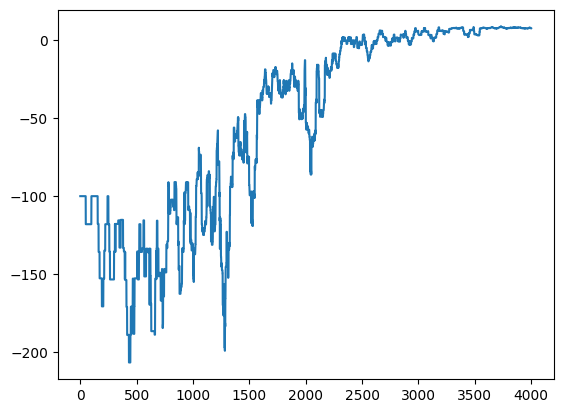

In [19]:
from IPython.display import clear_output
from collections import deque

option_agent = QLearningAgent(
    learning_rate=0.1, epsilon=0.05, gamma=0.95,
    get_legal_actions=lambda s: range(len(options)),
    seed=42
)

# создаем окружение, использующее опции
env = OptionTaxiStepWrapper(
    gym.make('Taxi-v3', max_episode_steps=100),
    options=options
)
rewards, rew_window = [], deque(maxlen=50)
for episode in range(4001):
    train_episode(env=env, agent=option_agent)
    rew_window.append(
        train_episode(env=env, agent=option_agent, is_eval=True)
    )
    rewards.append(np.mean(rew_window))

    if episode % 200 == 0:
        clear_output(True)
        plt.plot(rewards)
        plt.show()

hrl_results = rewards

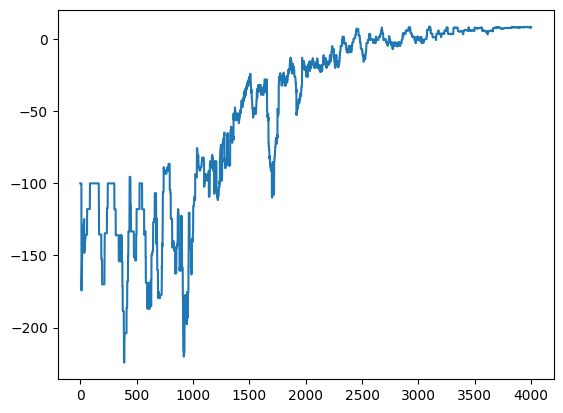

In [20]:
raw_agent = QLearningAgent(
    learning_rate=0.1, epsilon=0.05, gamma=0.95,
    get_legal_actions=lambda s: range(6),
    seed=42
)

# создаем окружение, использующее опции
env = gym.make('Taxi-v3', max_episode_steps=100)
rewards, rew_window = [], deque(maxlen=50)
for episode in range(4001):
    train_episode(env=env, agent=raw_agent)
    rew_window.append(
        train_episode(env=env, agent=raw_agent, is_eval=True)
    )
    rewards.append(np.mean(rew_window))

    if episode % 200 == 0:
        clear_output(True)
        plt.plot(rewards)
        plt.show()

rl_results = rewards

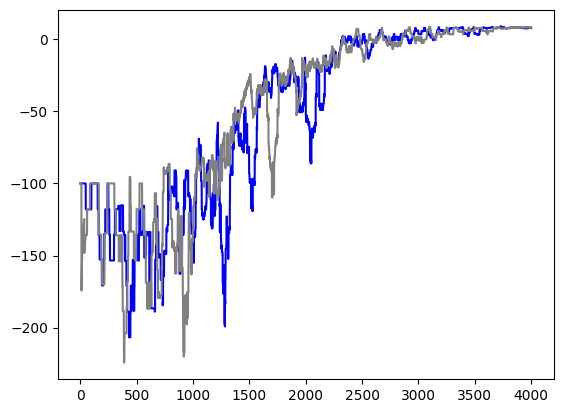

In [21]:
plt.plot(hrl_results, 'blue')
plt.plot(rl_results, 'gray')